In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set_context('paper', font_scale=2)
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit

In [63]:
df = pd.read_csv('Data/Price_5m.csv')
df.time_m = pd.to_datetime(df.time_m)
price = df.groupby(df.time_m.dt.date).price_avg.mean()

In [73]:
# DDOF == 0 OR 1 ?????
def RV(ser, w):
    roller = ser.rolling(window=w)
    return roller.std(ddof=1) * np.sqrt(365 / w)

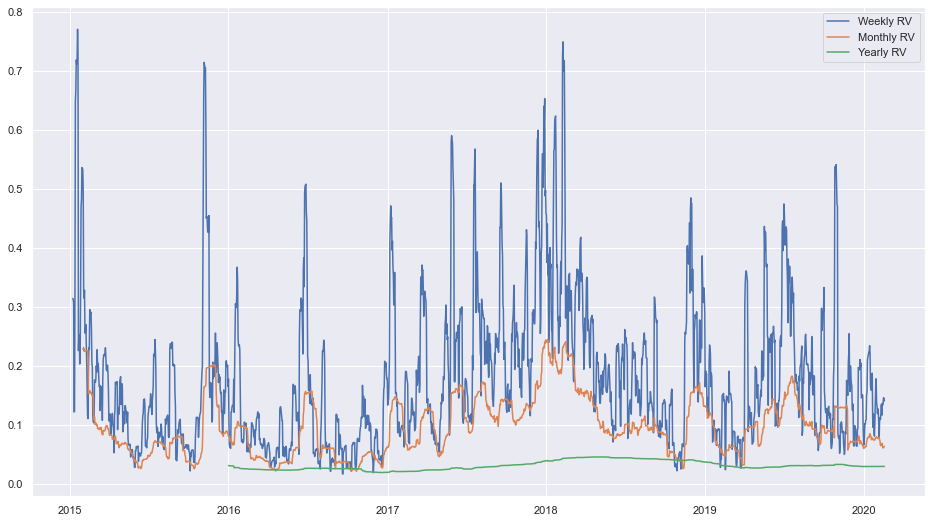

In [74]:
logret = np.log(price / price.shift())

rv7 = RV(logret, 7)
rv30 = RV(logret, 30)
rv365 = RV(logret, 365)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(rv7, label='Weekly RV')
ax.plot(rv30, label='Monthly RV')
ax.plot(rv365, label='Yearly RV')
plt.legend()
plt.show()

In [2]:
# Non normality of BTC log returns

df = pd.read_csv('Data/Price_5m.csv')
df['time_m'] = pd.to_datetime(df['time_m'])
df = df.resample('1d', on='time_m').mean()
log_returns = np.log(df['price_avg']/df['price_avg'].shift())
normalized_log_returns = (log_returns - log_returns.mean()) / log_returns.std()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


max 2017-12-07 00:00:00 5.400005463229835 P> = 3.331943376760904e-08
min 2015-01-14 00:00:00 -7.502973461967951 P< = 3.119309328090595e-14


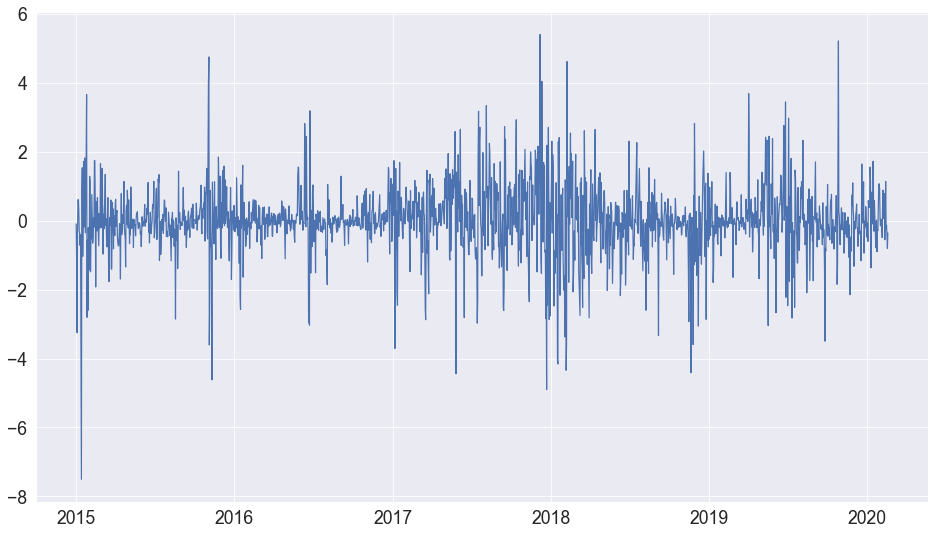

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.plot(normalized_log_returns)
# plt.ylabel('Normalized logarithmic return')
plt.savefig('Plots/normalized_log_returns.eps')
print('max', normalized_log_returns.idxmax(), normalized_log_returns.max(), f'P> = {1 - norm.cdf(normalized_log_returns.max())}')
print('min', normalized_log_returns.idxmin(), normalized_log_returns.min(), f'P< = {norm.cdf(normalized_log_returns.min())}')

kurtosis = 5.618172326199145
skew = -0.36385619622446314


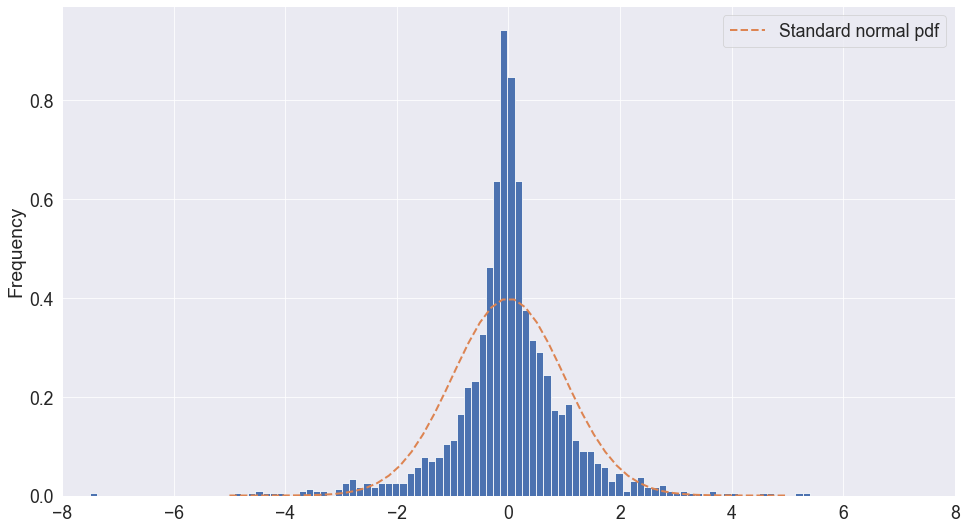

In [240]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
x = np.linspace(-5, 5)
gaussian = norm.pdf(x)
ax.set_xlim([-8, 8])
normalized_log_returns.hist(bins=100, density=True)
plt.plot(x, gaussian, '--', linewidth=2, label='Standard normal pdf')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Plots/log_returns_hist.png', bbox_inches='tight')
print(f'kurtosis = {normalized_log_returns.kurtosis()}')
print(f'skew = {normalized_log_returns.skew()}')

In [7]:
# qq plot
# import statsmodels.graphics.gofplots as gofplots
# fig, ax = plt.subplots(1, 1, figsize=(16, 9))
# gofplots.qqplot(normalized_log_returns, ax=ax)
# plt.show()

date = 2020-01-08 00:00:00
tt = 0.7146411295603379
St = 8461.01


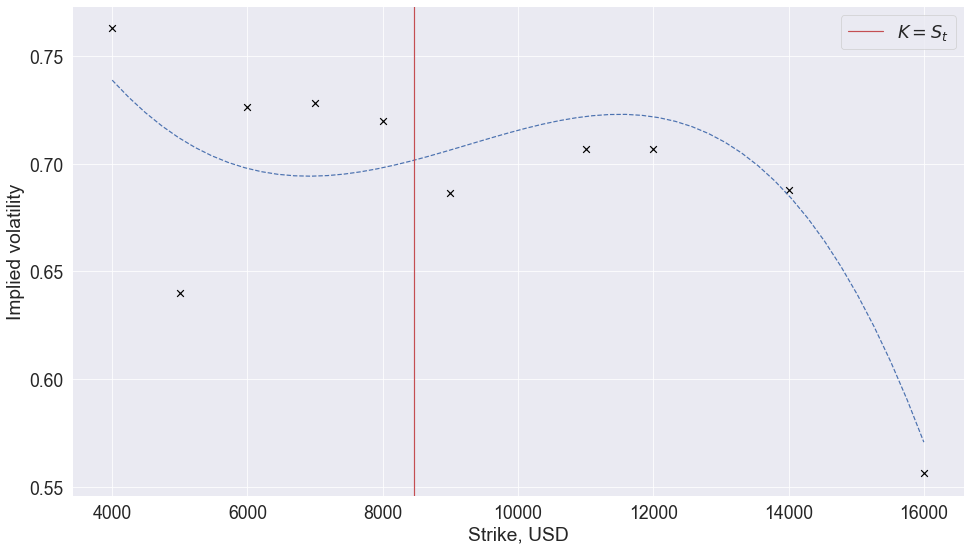

In [244]:
# VOLATILITY SMILE
data = pd.read_csv('Data/data.csv')
data = data[data.type=='put']
data.date = pd.to_datetime(data.date)
data.time_expire = pd.to_datetime(data.time_expire)
data = data[data.tt > 0.7]

max_strikes_date = data.groupby(['date', 'time_expire'])['strike'].nunique().idxmax()
print(f'date = {max_strikes_date[0]}')
data = data[(data.date == max_strikes_date[0]) & (data.time_expire == max_strikes_date[1])]
print(f'tt = {data.tt.mean()}')
ix_price = data.index_price.max()
print(f'St = {ix_price}')
data = data.groupby('strike')['iv_Tbill'].mean().reset_index()

# ATM correction
data.loc[(data.strike>4999) & (data.strike<5500), 'iv_Tbill'] = 64

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.scatter(data['strike'], data['iv_Tbill']/100, marker='x', color='black', s=45)

x = np.linspace(data['strike'].min(), data['strike'].max(), num=len(data.strike))
p = np.poly1d(np.polyfit(x, data['iv_Tbill']/100, 4))
x_interp = np.linspace(data['strike'].min(), data['strike'].max())
plt.plot(x_interp, p(x_interp), '--')
plt.axvline(ix_price, color='r', label='$K = S_t$')


plt.ylabel('Implied volatility')
plt.xlabel('Strike, USD')
plt.legend()
plt.savefig('Plots/vol_smile.png', bbox_inches='tight')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


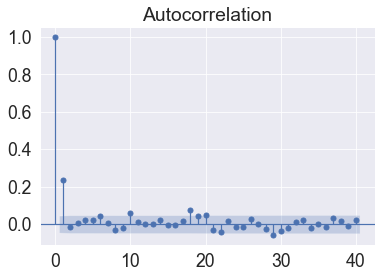

In [255]:
# VOLATILITY CLUSTERING: AUTOCORRELATION
import statsmodels.api as sm
df = pd.read_csv('Data/Price_5m.csv')
df['time_m'] = pd.to_datetime(df['time_m'])
df = df.resample('1d', on='time_m').mean()
log_returns = np.log(df['price_avg']/df['price_avg'].shift())
normalized_log_returns = (log_returns - log_returns.mean()) / log_returns.std()


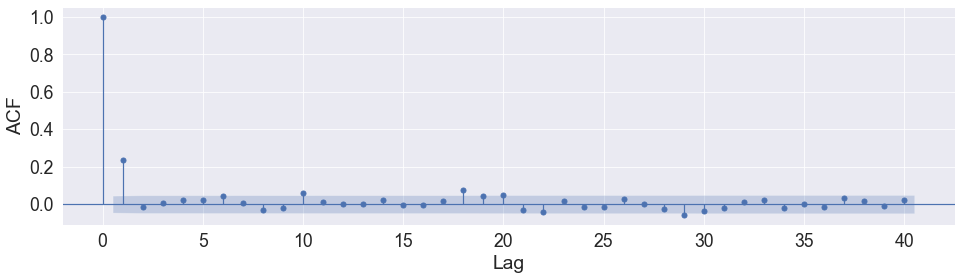

In [281]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
log_returns_acf = sm.graphics.tsa.plot_acf(normalized_log_returns[1:], lags=40, ax=ax, title=None)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.savefig('Plots/acf_logreturns.png', bbox_inches='tight')

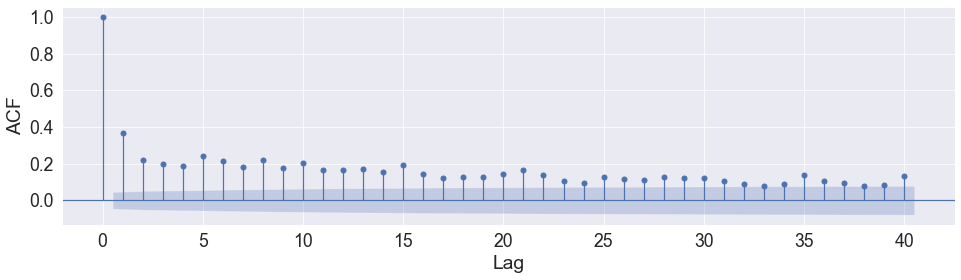

In [282]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
log_returns_acf = sm.graphics.tsa.plot_acf(np.abs(normalized_log_returns[1:]), lags=40, ax=ax, title=None)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.savefig('Plots/acf_abs_logreturns.png', bbox_inches='tight')

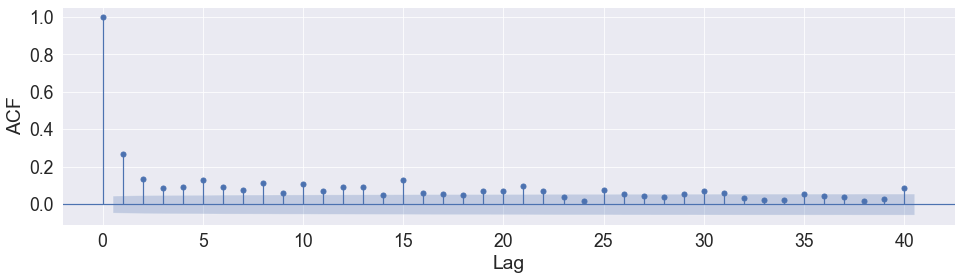

In [283]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
log_returns_acf = sm.graphics.tsa.plot_acf((normalized_log_returns[1:])**2, lags=40, ax=ax, title=None)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.savefig('Plots/acf_sq_logreturns.png', bbox_inches='tight')